## Python code to process phage genome annotation files and generate Figure 1a and Supplementary Figures 2 and 3
### Circular genome vizualizations were performed using python package pycirclize v1.9.1(https://github.com/moshi4/pyCirclize) and comparative genome map was generated using python package pygenomeviz v1.6.1(https://github.com/moshi4/pygenomeviz)

In [1]:
from pycirclize import Circos
from pycirclize.parser import Gff, Genbank
from pycirclize.utils import load_prokaryote_example_file, ColorCycler
from pygenomeviz import GenomeViz
from matplotlib.lines import Line2D
import pandas as pd
import numpy as np
import seaborn as sns
import glob
import matplotlib.pyplot as plt
import matplotlib
import pypalettes
from pypalettes import load_cmap
from pypalettes import get_hex
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from matplotlib.patches import Patch

## For slick and colony phage genomes (T.NPSG.1 and T.NPSG.2), read in manually validated annotations and update genbank file produced by Phold with these annotations

In [2]:
slick_annotations = pd.read_csv('annotation_files/unified_annotations_slick.csv').dropna(how='all',axis=1)
#remove empty rows
slick_annotations=slick_annotations[~slick_annotations['contig_id'].isna()]
#order CDS start and end
slick_annotations.loc[:,'start2'] = slick_annotations[['start','end']].min(axis=1).astype(int)
slick_annotations.loc[:,'end2'] = slick_annotations[['start','end']].max(axis=1).astype(int)
#fill NAs with consistent values
slick_annotations.loc[:,'Closest match category'] = slick_annotations['Closest match category'].fillna('No match')
slick_annotations.loc[:,'Closest viral match'] = slick_annotations['Closest viral match'].fillna('No match')
slick_annotations.loc[:,'Closest match'] = slick_annotations['Closest match'].fillna('No match')
slick_annotations.loc[:,'short_name'] = slick_annotations['short_name'].fillna('hypothetical protein')
slick_annotations.loc[:,'function'] = slick_annotations['function'].fillna('unknown function')
slick_annotations = slick_annotations.set_index('cds_id')
#generate BED file for slick genome and save file
slick_bed = slick_annotations[['contig_id','start','end']]
slick_bed.loc[:,'start'] = slick_annotations[['start','end']].min(axis=1)
slick_bed.loc[:,'end'] = slick_annotations[['start','end']].max(axis=1)
#slick_bed.to_csv('annotation_files/slick_genes.bed',sep='\t',index=False)

In [3]:
#repeat above for colony phage annotations
col_annotations = pd.read_csv('annotation_files/unified_annotations_col.csv').dropna(how='all',axis=1)
col_annotations=col_annotations[~col_annotations['contig_id'].isna()]
col_annotations.loc[:,'start2'] = col_annotations[['start','end']].min(axis=1).astype(int)
col_annotations.loc[:,'end2'] = col_annotations[['start','end']].max(axis=1).astype(int)
col_annotations.loc[:,'Closest match category'] = col_annotations['Closest match category'].fillna('No match')
col_annotations.loc[:,'Closest viral match'] = col_annotations['Closest viral match'].fillna('No match')
col_annotations.loc[:,'Closest match'] = col_annotations['Closest match'].fillna('No match')
col_annotations.loc[:,'short_name'] = col_annotations['short_name'].fillna('hypothetical protein')
col_annotations.loc[:,'function'] = col_annotations['function'].fillna('unknown function')
col_annotations = col_annotations.set_index('cds_id')
#generate BED file for colony genome and save file
col_bed = col_annotations[['contig_id','start','end']]
col_bed.loc[:,'start'] = col_bed[['start','end']].min(axis=1)
col_bed.loc[:,'end'] = col_bed[['start','end']].max(axis=1)
#col_bed.to_csv('annotation_files/col_genes.bed',sep='\t',index=False)

In [4]:
#read in GenBank file produced by Phold annotation of slick phage genome
slick_records = SeqIO.parse('annotation_files/slick_phold.gbk', "genbank")
genome = next(slick_records)

In [5]:
#loop over all CDSs and update according to unified annotations
for i in genome.features:
    qual_dict = i.qualifiers
    cds = qual_dict['ID']
    product = [slick_annotations.loc[cds]['short_name'].values[0]]
    function = [slick_annotations.loc[cds]['function'].values[0]]
    match_group = [slick_annotations.loc[cds]['Closest match category'].values[0]]
    qual_dict['function'] = function
    qual_dict['product'] = product
    qual_dict['match_group'] = match_group
    i.qualifiers = qual_dict
#SeqIO.write(genome, "annotation_files/tricho_phage_NPSG_2.gbk", "genbank")

In [6]:
feature_records = []  # List to store new SeqRecord objects for features

for feature in genome.features:
    if feature.type == "CDS" and "translation" in feature.qualifiers:
        # Create a new SeqRecord for each translated CDS
        feature_record = SeqRecord(
            Seq(feature.qualifiers["translation"][0]),
            id=feature.qualifiers.get("locus_tag", [feature.qualifiers.get("protein_id", [feature.id])])[0],  # Use locus_tag or protein_id as ID
            description=feature.qualifiers.get("product", [""])[0]  # Use product as description
        )
        feature_records.append(feature_record)

# Write the collected feature records to a new FASTA file
#SeqIO.write(feature_records, "annotation_files/slick_unified.faa","fasta")

In [7]:
#genes whose CDSs need to be separated:
sep = {76961:[76961,78421,78427,91440],104748:[104039,102999,104748,103966],121086:[121065,121826,121844,123043],136572:[136572,136982,136966,137295]}

In [8]:
#write out feature table for genbank submission
quals = ['locus_tag','product','transl_table']
with open('annotation_files/feature_table_2.txt','w') as newfile:
    newfile.write('>Feature T.NPSG.2\n')
    for feature in genome.features:
        #for each feature, line for gene and CDS
        if feature.location.strand == 1:
            start = int(feature.location.start)+1
            end = int(feature.location.end)
        else:
            start = int(feature.location.end)
            end = int(feature.location.start)
        #gene first
        newfile.write(str(start) +'\t'+ str(end) +'\tgene\n')
        newfile.write('\t\t\tlocus_tag\t'+feature.qualifiers.get('locus_tag')[0]+'\n')

        #CDS
        
        if start in sep.keys():
            newfile.write(str(sep[start][0]) +'\t'+ str(sep[start][1]) +'\tCDS\n')
            for j in quals:
                value = feature.qualifiers.get(j)[0]
                newfile.write('\t\t\t'+j+'\t'+value+'\n')
                
            newfile.write(str(sep[start][2]) +'\t'+ str(sep[start][3]) +'\tCDS\n')
            for j in quals:
                value = feature.qualifiers.get(j)[0]
                newfile.write('\t\t\t'+j+'\t'+value+'\n')
            
        else:
            newfile.write(str(start) +'\t'+ str(end) +'\tCDS\n')
            for j in quals:
                value = feature.qualifiers.get(j)[0]
                newfile.write('\t\t\t'+j+'\t'+value+'\n')
    newfile.close()

In [9]:
#repeat above for colony phage genome
col_records = SeqIO.parse('annotation_files/col_phold.gbk', "genbank")
genome = next(col_records)

#loop over all CDSs and update according to unified annotations
for i in genome.features:
    qual_dict = i.qualifiers
    cds = qual_dict['ID']
    product = [col_annotations.loc[cds]['short_name'].values[0]]
    function = [col_annotations.loc[cds]['function'].values[0]]
    match_group = [col_annotations.loc[cds]['Closest match category'].values[0]]
    qual_dict['function'] = function
    qual_dict['product'] = product
    qual_dict['match_group'] = match_group
    i.qualifiers = qual_dict
SeqIO.write(genome, "annotation_files/tricho_phage_NPSG_1.gbk", "genbank")

feature_records = []  # List to store new SeqRecord objects for features

for feature in genome.features:
    if feature.type == "CDS" and "translation" in feature.qualifiers:
        # Create a new SeqRecord for each translated CDS
        feature_record = SeqRecord(
            Seq(feature.qualifiers["translation"][0]),
            id=feature.qualifiers.get("locus_tag", [feature.qualifiers.get("protein_id", [feature.id])])[0],  # Use locus_tag or protein_id as ID
            description=feature.qualifiers.get("product", [""])[0]  # Use product as description
        )
        feature_records.append(feature_record)

# Write the collected feature records to a new FASTA file
#SeqIO.write(feature_records, "annotation_files/col_unified.faa","fasta")

In [10]:
#write out feature table for genbank submission
quals = ['locus_tag','product','transl_table']
with open('annotation_files/feature_table_1.txt','w') as newfile:
    newfile.write('>Feature T.NPSG.1\n')
    for feature in genome.features:
        #for each feature, line for gene and CDS
        if feature.location.strand == 1:
            start = int(feature.location.start)+1
            end = int(feature.location.end)
        else:
            start = int(feature.location.end)
            end = int(feature.location.start)
        #gene first
        newfile.write(str(start) +'\t'+ str(end) +'\tgene\n')
        newfile.write('\t\t\tlocus_tag\t'+feature.qualifiers.get('locus_tag')[0]+'\n')

        #CDS
        newfile.write(str(start) +'\t'+ str(end) +'\tCDS\n')
        for j in quals:
            value = feature.qualifiers.get(j)[0]
            newfile.write('\t\t\t'+j+'\t'+value+'\n')
    newfile.close()

## Make genomic features circos plot

In [11]:
#Set color palette
hex_colors = load_cmap("golduck").hex
function_palette = {'tail':hex_colors[5], 'head and packaging':hex_colors[8],
                    'DNA, RNA and nucleotide metabolism':hex_colors[0],'integration and excision':hex_colors[1],'transcription regulation':hex_colors[2],'RM system':hex_colors[3], 'Phage defense':'#d0eafb',
                   'auxiliary metabolism, host takeover':hex_colors[9],'Host range determination':hex_colors[12],'lysis':hex_colors[11],
                    'unknown function':'#cccccc', 'conserved protein of unknown function':'#000000'}

hex_colors2 = load_cmap("Ofrenda").hex
match_palette = {'No match':'#FFFFFF00','Bacterium':hex_colors2[5],'Cyanobacterium':hex_colors2[6], 'Diazotrophic cyanobacterium':hex_colors2[7], 'Trichodesmium':hex_colors2[8],
'Caudoviricetes':hex_colors2[3],'Cyanophage':hex_colors2[1],'Diazotroph phage':'#4E301E'}

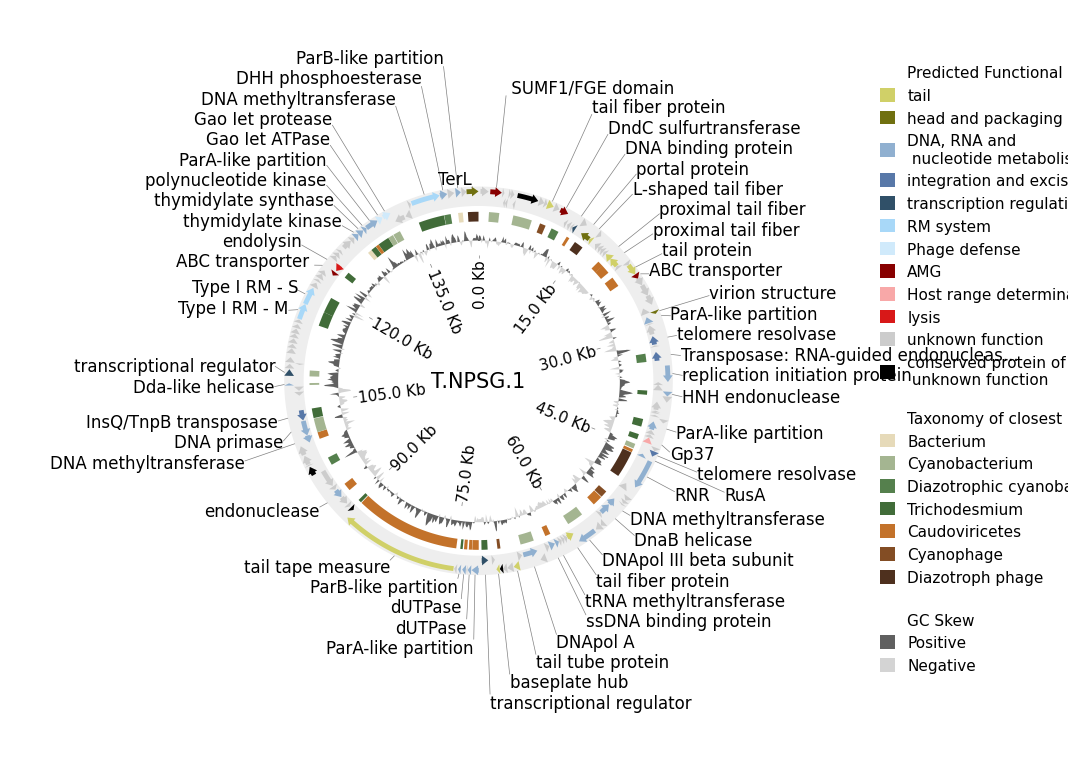

In [12]:
#Start with colony phage
gbk = Genbank('annotation_files/tricho_phage_NPSG_1.gbk')

seqid2size = gbk.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("T.NPSG.1", size=15)
seqid2features = gbk.get_seqid2features(feature_type="CDS")
seqid2seq = gbk.get_seqid2seq()

for sector in circos.sectors:
    cds_track = sector.add_track((90, 100))
    cds_track.axis(fc="#EEEEEE", ec="none")
    
    match_track = sector.add_track((82,87))
    
    features = seqid2features[sector.name]
    label_pos_list, labels = [], []
    for feature in features:
        # Plot CDS features
        if feature.location.strand == 1:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(95, 100), fc=function_palette[feature.qualifiers.get("function", [""])[0]])
        else:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(90, 95), fc=function_palette[feature.qualifiers.get("function", [""])[0]])
        match_track.genomic_features(feature,r_lim=(82,87),fc=match_palette[feature.qualifiers.get("match_group")[0]])
        # Extract feature product label & position
        start, end = int(feature.location.start), int(feature.location.end)
        label_pos = (start + end) / 2
        label = feature.qualifiers.get("product", [""])[0]
        if label == "" or label.startswith("hypothetical"):
            continue
        cds_track.annotate(label_pos, label, label_size=12,shorten=35)

    gc_skew_track = sector.add_track((65,80))
    seq = seqid2seq[sector.name]
    label_pos_list, gc_skews = gbk.calc_gc_skew(seq=seq)
    positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
    negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
    abs_max_gc_skew = np.max(np.abs(gc_skews))
    vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
    gc_skew_track.fill_between(
        label_pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="#606060FF"
    )
    gc_skew_track.fill_between(
        label_pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="#D4D4D4FF"
    )
    
    # Plot xticks & intervals on inner position
    gc_skew_track.xticks_by_interval(
        interval=15000,
        outer=False,
        label_formatter=lambda v: f"{v/ 1000:.1f} Kb",
        label_orientation="vertical",
        line_kws=dict(ec="grey"),
        label_size=11,
    )

fig = circos.plotfig(figsize=(10,24))

handles1 = []
handles1.append(Patch(color='#FFFFFF00',label='Predicted Functional Category'))
for i in function_palette.keys():
    if i == 'conserved protein of unknown function':
        handles1.append(Patch(color=function_palette[i],label='conserved protein of \n unknown function'))
    elif i == 'DNA, RNA and nucleotide metabolism':
        handles1.append(Patch(color=function_palette[i],label='DNA, RNA and \n nucleotide metabolism'))
    elif i == 'auxiliary metabolism, host takeover':
        handles1.append(Patch(color=function_palette[i],label='AMG'))
    else:
        handles1.append(Patch(color=function_palette[i],label=i))
handles2 = []
handles2.append(Patch(color='#FFFFFF00',label='Taxonomy of closest NCBI-NR hit'))
for i in match_palette.keys():
    if i == 'No match':
        pass
    else:
        handles2.append(Patch(color=match_palette[i],label=i))
first_legend = circos.ax.legend(handles=handles1, bbox_to_anchor=(1.45,.45), loc="lower left", fontsize=11)
circos.ax.add_artist(first_legend)
second_legend = circos.ax.legend(handles=handles2, bbox_to_anchor=(1.45,.46), loc="upper left", fontsize=11)
circos.ax.add_artist(second_legend)
third_legend = circos.ax.legend(handles=[Patch(color='#FFFFFF00',label='GC Skew'),Patch(color="#606060FF",label='Positive'),Patch(color="#D4D4D4FF",label="Negative")], bbox_to_anchor=(1.45,-.25), loc="lower left", fontsize=11)
#fig.savefig('output_figures/fig1a_col_phage.svg',transparent = True,bbox_inches='tight',pad_inches=2)
plt.show()

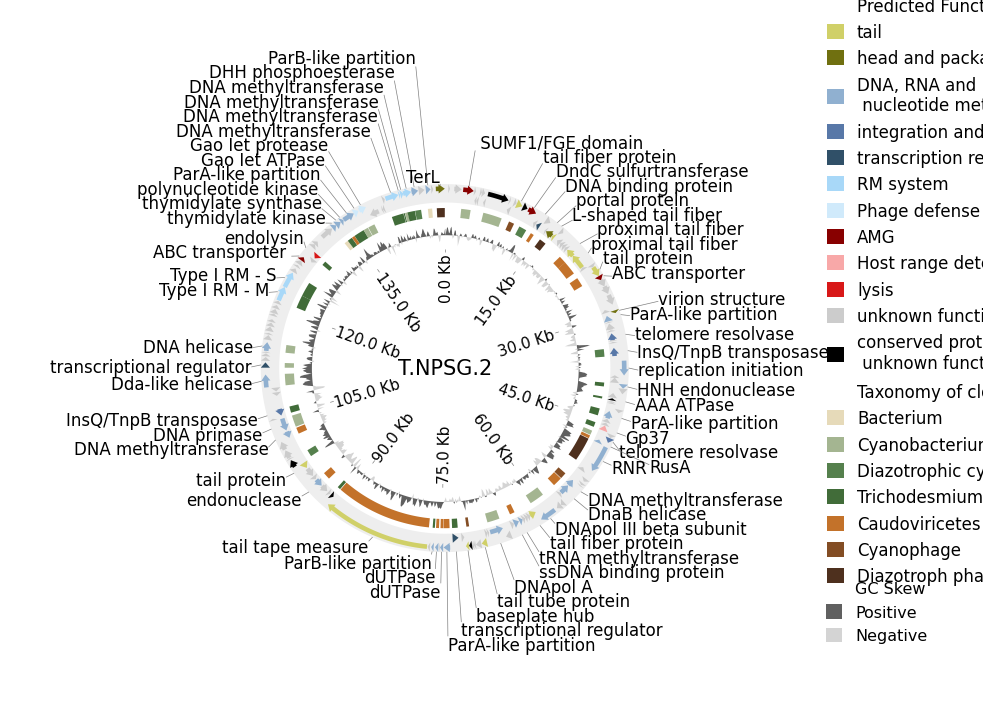

In [13]:
#Repeat for slick phage
gbk = Genbank('annotation_files/tricho_phage_NPSG_2.gbk')

seqid2size = gbk.get_seqid2size()
space = 0 if len(seqid2size) == 1 else 2
circos = Circos(sectors=seqid2size, space=space)
circos.text("T.NPSG.2", size=15)
seqid2features = gbk.get_seqid2features(feature_type="CDS")
seqid2seq = gbk.get_seqid2seq()

for sector in circos.sectors:
    cds_track = sector.add_track((90, 100))
    cds_track.axis(fc="#EEEEEE", ec="none")
    
    match_track = sector.add_track((82,87))
    
    features = seqid2features[sector.name]
    label_pos_list, labels = [], []
    for feature in features:
        # Plot CDS features
        if feature.location.strand == 1:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(95, 100), fc=function_palette[feature.qualifiers.get("function", [""])[0]])
        else:
            cds_track.genomic_features(feature, plotstyle="arrow", r_lim=(90, 95), fc=function_palette[feature.qualifiers.get("function", [""])[0]])
        match_track.genomic_features(feature,r_lim=(82,87),fc=match_palette[feature.qualifiers.get("match_group")[0]])
        # Extract feature product label & position
        start, end = int(feature.location.start), int(feature.location.end)
        label_pos = (start + end) / 2
        label = feature.qualifiers.get("product", [""])[0]
        if label == "" or label.startswith("hypothetical"):
            continue
        cds_track.annotate(label_pos, label, label_size=12,shorten=35)

    gc_skew_track = sector.add_track((65,80))
    seq = seqid2seq[sector.name]
    label_pos_list, gc_skews = gbk.calc_gc_skew(seq=seq)
    positive_gc_skews = np.where(gc_skews > 0, gc_skews, 0)
    negative_gc_skews = np.where(gc_skews < 0, gc_skews, 0)
    abs_max_gc_skew = np.max(np.abs(gc_skews))
    vmin, vmax = -abs_max_gc_skew, abs_max_gc_skew
    gc_skew_track.fill_between(
        label_pos_list, positive_gc_skews, 0, vmin=vmin, vmax=vmax, color="#606060FF"
    )
    gc_skew_track.fill_between(
        label_pos_list, negative_gc_skews, 0, vmin=vmin, vmax=vmax, color="#D4D4D4FF"
    )
    
    # Plot xticks & intervals on inner position
    gc_skew_track.xticks_by_interval(
        interval=15000,
        outer=False,
        label_formatter=lambda v: f"{v/ 1000:.1f} Kb",
        label_orientation="vertical",
        line_kws=dict(ec="grey"),
        label_size=11,
    )

fig = circos.plotfig(figsize=(10,24))

handles1 = []
handles1.append(Patch(color='#FFFFFF00',label='Predicted Functional Category'))
for i in function_palette.keys():
    if i == 'conserved protein of unknown function':
        handles1.append(Patch(color=function_palette[i],label='conserved protein of \n unknown function'))
    elif i == 'DNA, RNA and nucleotide metabolism':
        handles1.append(Patch(color=function_palette[i],label='DNA, RNA and \n nucleotide metabolism'))
    elif i == 'auxiliary metabolism, host takeover':
        handles1.append(Patch(color=function_palette[i],label='AMG'))
    else:
        handles1.append(Patch(color=function_palette[i],label=i))
handles2 = []
handles2.append(Patch(color='#FFFFFF00',label='Taxonomy of closest NCBI-NR hit'))
for i in match_palette.keys():
    if i == 'No match':
        pass
    else:
        handles2.append(Patch(color=match_palette[i],label=i))
first_legend = circos.ax.legend(handles=handles1, bbox_to_anchor=(1.45,.45), loc="lower left", fontsize=12)
circos.ax.add_artist(first_legend)
second_legend = circos.ax.legend(handles=handles2, bbox_to_anchor=(1.45,.5), loc="upper left", fontsize=12)
circos.ax.add_artist(second_legend)
third_legend = circos.ax.legend(handles=[Patch(color='#FFFFFF00',label='GC Skew'),Patch(color="#606060FF",label='Positive'),Patch(color="#D4D4D4FF",label="Negative")], bbox_to_anchor=(1.45,-.25), loc="lower left", fontsize=11.5)
#fig.savefig('output_figures/supp_fig_slick_phage.svg',transparent = True,bbox_inches='tight',pad_inches=2)
plt.show()

## Make comparative genome plot

In [14]:
gbk_list=list(map(Genbank, ['annotation_files/tricho_phage_NPSG_1.gbk','annotation_files/tricho_phage_NPSG_2.gbk']))
align_coords = pd.read_csv('annotation_files/col_v_slick_phage_blastn.out',sep='\t',names=['qseqid','sseqid','pident','length','mismatch','gapopen','qlen','qstart','qend','slen','sstart','send','evalue','bitscore'],header=None)

tricho_phage_NPSG_1
tricho_phage_NPSG_2


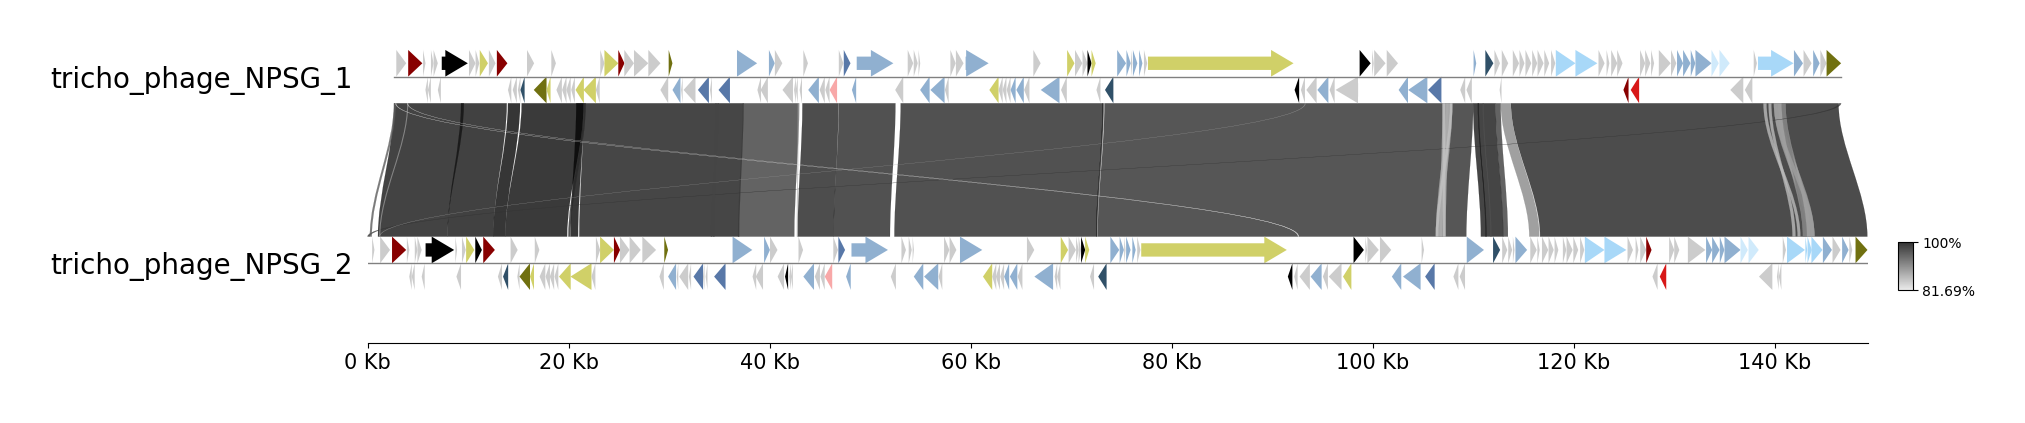

In [15]:
gv = GenomeViz(fig_track_height=0.8, feature_track_ratio=0.4,track_align_type='center')
gv.set_scale_xticks()

for gbk in gbk_list:
    print(gbk.name)
    track = gv.add_feature_track(gbk.name, gbk.get_seqid2size(), align_label=True)
    for seqid, features in gbk.get_seqid2features("CDS").items():
        for feature in features:
            track.add_features(feature, plotstyle="arrow", fc=function_palette[feature.qualifiers.get("function", [""])[0]])

#add coordinates
min_ident = align_coords['pident'].min()
#Loop over all matches
for index,row in align_coords.iterrows():
    gv.add_link(('tricho_phage_NPSG_1',row['sstart'],row['send']),('tricho_phage_NPSG_2',row['qstart'],row['qend']),color='black',v=row['pident'],vmin=min_ident,curve=True)
gv.set_colorbar(['black'], vmin=min_ident)
fig = gv.plotfig()
#fig.savefig('output_figures/supp_fig_genome_comp.svg',transparent = True,bbox_inches='tight')
plt.show()